# Examine consistency and importance pattern similarity

In [1]:
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
import math
import scipy
import random
from tqdm import tqdm

#from experiments.causal_trace import plot_trace_heatmap, plot_trace_heatmap_from_values, plot_normalized_trace_heatmap_from_values

In [2]:
relations = ["P19", "P20", "P27", "P101", "P495", "P740", "P1376"]
model_name = "llama7B"

data_folder = "/cephyr/users/lovhag/Alvis/projects/rome/data/RQ1"

In [3]:
data = pd.DataFrame()

for relation in relations:
    tmp_data = pd.read_csv(os.path.join(data_folder, model_name, f"{relation}.csv"))
    tmp_data["relation"] = relation
    data = data.append(tmp_data, ignore_index=True)
        
data

,sample_ix,lama_ix,subject,lama_template,sample_template,lama_answer,sample_answer,correct_answer,lama_correct,sample_correct,lama_te,sample_te,is_consistent,pairwise_sim,subj_len,token_ix,pred_type,relation
0,1,0,Paul Mounsey,{} was born in,{} is originally from,NaN,the,Scotland,False,False,-1.163617e-09,-2.419047e-09,False,0.991105,4,0,any,P19
1,1,0,Paul Mounsey,{} was born in,{} is originally from,London,London,Scotland,False,False,4.872738e-02,1.650523e-02,True,0.997059,4,1,candidate,P19
2,2,0,Paul Mounsey,{} was born in,{} was originally from,NaN,the,Scotland,False,False,-1.163617e-09,-1.179719e-09,False,0.960392,4,0,any,P19
3,2,0,Paul Mounsey,{} was born in,{} was originally from,London,London,Scotland,False,False,4.872738e-02,1.687679e-02,True,0.997320,4,1,candidate,P19
4,3,0,Paul Mounsey,{} was born in,{} is native to,NaN,the,Scotland,False,False,-1.163617e-09,-2.751592e-10,False,0.926478,4,0,any,P19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58876,447,444,Topeka,{} is the capital of,"{}, the capital city of",Kansas,Kansas,Kansas,True,True,5.252777e-01,8.945650e-01,True,0.971347,3,0,candidate,P1376
58877,448,444,Topeka,{} is the capital of,"{}, that is the capital of",Kansas,Kansas,Kansas,True,True,5.252777e-01,7.327066e-01,True,0.984375,3,0,any,P1376
58878,448,444,Topeka,{} is the capital of,"{}, that is the capital of",Kansas,Kansas,Kansas,True,True,5.252777e-01,7.327066e-01,True,0.984375,3,0,candidate,P1376
58879,449,444,Topeka,{} is the capital of,"{}, that is the capital city of",Kansas,Kansas,Kansas,True,True,5.252777e-01,8.134425e-01,True,0.963304,3,0,any,P1376


In [4]:
data.pred_type.value_counts()

any          33456
candidate    25425
Name: pred_type, dtype: int64

## Similarity values measured before filtering objects and TE thresholding

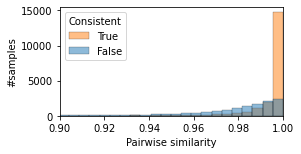

In [5]:
plt.figure(figsize=(4,2))
sns.histplot(data=data[data.pred_type=="any"], x="pairwise_sim", hue="is_consistent", bins=100)
plt.xlim([0.9, 1])
plt.xlabel("Pairwise similarity")
plt.ylabel("#samples")
plt.legend(title='Consistent', loc='upper left', labels=['True', 'False'])
plt.savefig("/cephyr/users/lovhag/Alvis/projects/rome/images/llama_sim_cons_any_te_any_obj.svg")
plt.show()

In [6]:
data[data.pred_type=="any"].pairwise_sim.mean()

0.9869044105350293

In [7]:
data[data.pred_type=="any"].pairwise_sim.min()

0.5438697636127472

In [8]:
data[data.pred_type=="any"].pairwise_sim.std()

0.022194334606241945

## Get similarities and corresponding consistency values for pairwise comparisons between the LAMA template and other templates

**Important step:** Remove forbidden predictions to make certain we are only considering fact recall processes.

> Thoughts: Is "works in the field of [digital]" or "works in the field of [human]" ok?

In [9]:
forbidden_predictions = ["a", "the", "collaboration", "response", "public", '"', "order", "partnership", "honor", "AD", "open", "H", "age", "creating", "disgrace", "her", "his", "in", "left", "not", "providing", "tragedy", "which", "whom", "I", "non", "cy", "Se", "Tw", "ac", "ps", "Te", "ne", "spe", "B", "compar", "bi", "Pe"]
print("Removing the forbidden predictions for the LAMA paraphrases...")
print(data[data.lama_answer.isin(forbidden_predictions)].lama_answer.value_counts())

forbidden_mask = (data.lama_answer.isin(forbidden_predictions))# | (data.sample_answer.isin(forbidden_predictions))
data = data[~(forbidden_mask)].reset_index(drop=True)
data

Removing the forbidden predictions for the LAMA paraphrases...
the       3247
a           63
public      18
Pe          13
his          7
cy           6
ac           6
ps           6
non          6
Te           6
B            6
Se           6
spe          6
ne           6
I            6
bi           6
compar       6
open         6
Tw           6
Name: lama_answer, dtype: int64


,sample_ix,lama_ix,subject,lama_template,sample_template,lama_answer,sample_answer,correct_answer,lama_correct,sample_correct,lama_te,sample_te,is_consistent,pairwise_sim,subj_len,token_ix,pred_type,relation
0,1,0,Paul Mounsey,{} was born in,{} is originally from,NaN,the,Scotland,False,False,-1.163617e-09,-2.419047e-09,False,0.991105,4,0,any,P19
1,1,0,Paul Mounsey,{} was born in,{} is originally from,London,London,Scotland,False,False,4.872738e-02,1.650523e-02,True,0.997059,4,1,candidate,P19
2,2,0,Paul Mounsey,{} was born in,{} was originally from,NaN,the,Scotland,False,False,-1.163617e-09,-1.179719e-09,False,0.960392,4,0,any,P19
3,2,0,Paul Mounsey,{} was born in,{} was originally from,London,London,Scotland,False,False,4.872738e-02,1.687679e-02,True,0.997320,4,1,candidate,P19
4,3,0,Paul Mounsey,{} was born in,{} is native to,NaN,the,Scotland,False,False,-1.163617e-09,-2.751592e-10,False,0.926478,4,0,any,P19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55444,447,444,Topeka,{} is the capital of,"{}, the capital city of",Kansas,Kansas,Kansas,True,True,5.252777e-01,8.945650e-01,True,0.971347,3,0,candidate,P1376
55445,448,444,Topeka,{} is the capital of,"{}, that is the capital of",Kansas,Kansas,Kansas,True,True,5.252777e-01,7.327066e-01,True,0.984375,3,0,any,P1376
55446,448,444,Topeka,{} is the capital of,"{}, that is the capital of",Kansas,Kansas,Kansas,True,True,5.252777e-01,7.327066e-01,True,0.984375,3,0,candidate,P1376
55447,449,444,Topeka,{} is the capital of,"{}, that is the capital city of",Kansas,Kansas,Kansas,True,True,5.252777e-01,8.134425e-01,True,0.963304,3,0,any,P1376


Check that the remaining predictions are ok...

In [10]:
pd.options.display.max_rows = 4000
print(data.lama_answer.value_counts())#.add(data.sample_answer.value_counts(), fill_value=0).head(1000)

London           2950
Japan            2505
France           1366
India            1355
Canada           1352
Paris            1182
Italy            1089
Chicago           748
Sweden            710
Germany           688
Rome              673
Australia         666
mathematics       540
Philadelphia      525
Berlin            501
Norway            491
Poland            449
Mexico            418
Brazil            401
Spain             399
Seattle           383
Moscow            376
physics           366
England           344
Montreal          342
Finland           332
Toronto           298
Boston            289
Tokyo             281
Ireland           267
Stockholm         267
Milan             257
Vienna            236
Dublin            221
Atlanta           212
Argentina         210
Switzerland       202
Amsterdam         195
Iran              188
Melbourne         178
art               174
Madrid            171
Austria           168
Detroit           166
Sydney            160
Israel    

In [11]:
test_token = "the"
data[(data.sample_answer==test_token) | (data.lama_answer==test_token)]

,sample_ix,lama_ix,subject,lama_template,sample_template,lama_answer,sample_answer,correct_answer,lama_correct,sample_correct,lama_te,sample_te,is_consistent,pairwise_sim,subj_len,token_ix,pred_type,relation
0,1,0,Paul Mounsey,{} was born in,{} is originally from,NaN,the,Scotland,False,False,-1.163617e-09,-2.419047e-09,False,0.991105,4,0,any,P19
2,2,0,Paul Mounsey,{} was born in,{} was originally from,NaN,the,Scotland,False,False,-1.163617e-09,-1.179719e-09,False,0.960392,4,0,any,P19
4,3,0,Paul Mounsey,{} was born in,{} is native to,NaN,the,Scotland,False,False,-1.163617e-09,-2.751592e-10,False,0.926478,4,0,any,P19
6,4,0,Paul Mounsey,{} was born in,{} was native to,NaN,the,Scotland,False,False,-1.163617e-09,-2.214266e-10,False,0.966645,4,0,any,P19
8,5,0,Paul Mounsey,{} was born in,{} originated from,NaN,the,Scotland,False,False,-1.163617e-09,4.969354e-10,False,0.957580,4,0,any,P19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54744,7863,7854,Dominion,{} was founded in,"{}, that originated in",NaN,the,Toronto,False,False,7.131666e-02,1.484522e-01,False,0.992391,2,0,any,P740
54809,7905,7896,Shirehorses,{} was founded in,"{}, that originated in",NaN,the,Manchester,False,False,1.312807e-01,-2.577452e-02,False,0.993504,5,0,any,P740
54810,7906,7896,Shirehorses,{} was founded in,{} originated in,NaN,the,Manchester,False,False,1.312807e-01,-1.933950e-02,False,0.989016,5,0,any,P740
55236,278,276,Westminster,{} is the capital of,"{}, the capital of",England,the,England,True,False,3.979647e-01,3.760648e-01,False,0.992160,3,0,any,P1376


LLaMA can output the empty string "". This seems to happen when the model generates sequences containing numbers. So if the model wishes to predict "Gummi candy was created in <1895>", it first needs to generate this empty string before it can generate numbers.

In [23]:
data[data.sample_answer.isna()]

,sample_ix,lama_ix,subject,lama_template,sample_template,lama_answer,sample_answer,correct_answer,lama_correct,sample_correct,lama_te,sample_te,is_consistent,pairwise_sim,subj_len,token_ix,pred_type,relation
5498,2,0,Charles Nodier,{} died in,{} passed away in,NaN,NaN,Paris,False,False,-4.614285e-10,-9.370348e-10,True,0.977947,4,0,any,P20
5506,6,0,Charles Nodier,{} died in,{}'s life ended in,NaN,NaN,Paris,False,False,-4.614285e-10,-1.262224e-10,True,0.991478,4,0,any,P20
5519,18,16,Salomon Sulzer,{} died in,{} passed away in,NaN,NaN,Vienna,False,False,-1.920607e-10,-1.035091e-10,True,0.977279,4,0,any,P20
5527,22,16,Salomon Sulzer,{} died in,{}'s life ended in,NaN,NaN,Vienna,False,False,-1.920607e-10,-9.151949e-11,True,0.975808,4,0,any,P20
5533,26,24,Michelangelo,{} died in,{} passed away in,NaN,NaN,Rome,False,False,-5.155505e-10,-9.406718e-10,True,0.966264,3,0,any,P20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54807,7903,7896,Shirehorses,{} was founded in,"{}, created in",NaN,NaN,Manchester,False,False,1.312807e-01,2.883089e-01,True,0.997518,5,0,any,P740
54808,7904,7896,Shirehorses,{} was founded in,{} was created in,NaN,NaN,Manchester,False,False,1.312807e-01,2.527262e-01,True,0.999602,5,0,any,P740
54811,7907,7896,Shirehorses,{} was founded in,{} formed in,NaN,NaN,Manchester,False,False,1.312807e-01,3.759632e-01,True,0.986297,5,0,any,P740
54812,7908,7896,Shirehorses,{} was founded in,{} was formed in,NaN,NaN,Manchester,False,False,1.312807e-01,1.525309e-01,True,0.999800,5,0,any,P740


<AxesSubplot:>

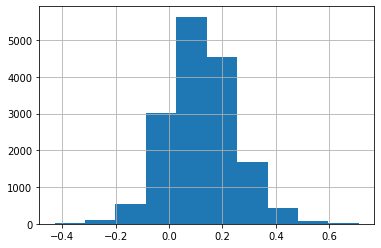

In [25]:
data[data.sample_answer.isna()].sample_te.hist()

For now it doesn't seem to make sense to include the empty token as an acceptable answer alternative. So we will remove all samples corresponding to such a prediction.

In [26]:
data = data.dropna()
data

,sample_ix,lama_ix,subject,lama_template,sample_template,lama_answer,sample_answer,correct_answer,lama_correct,sample_correct,lama_te,sample_te,is_consistent,pairwise_sim,subj_len,token_ix,pred_type,relation
1,1,0,Paul Mounsey,{} was born in,{} is originally from,London,London,Scotland,False,False,0.048727,0.016505,True,0.997059,4,1,candidate,P19
3,2,0,Paul Mounsey,{} was born in,{} was originally from,London,London,Scotland,False,False,0.048727,0.016877,True,0.997320,4,1,candidate,P19
5,3,0,Paul Mounsey,{} was born in,{} is native to,London,Chicago,Scotland,False,False,0.048727,0.006344,False,0.906182,4,1,candidate,P19
7,4,0,Paul Mounsey,{} was born in,{} was native to,London,London,Scotland,False,False,0.048727,0.012457,True,0.989730,4,1,candidate,P19
9,5,0,Paul Mounsey,{} was born in,{} originated from,London,London,Scotland,False,False,0.048727,0.021752,True,0.971953,4,1,candidate,P19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55444,447,444,Topeka,{} is the capital of,"{}, the capital city of",Kansas,Kansas,Kansas,True,True,0.525278,0.894565,True,0.971347,3,0,candidate,P1376
55445,448,444,Topeka,{} is the capital of,"{}, that is the capital of",Kansas,Kansas,Kansas,True,True,0.525278,0.732707,True,0.984375,3,0,any,P1376
55446,448,444,Topeka,{} is the capital of,"{}, that is the capital of",Kansas,Kansas,Kansas,True,True,0.525278,0.732707,True,0.984375,3,0,candidate,P1376
55447,449,444,Topeka,{} is the capital of,"{}, that is the capital city of",Kansas,Kansas,Kansas,True,True,0.525278,0.813442,True,0.963304,3,0,any,P1376


## Similarity values measured before TE thresholding

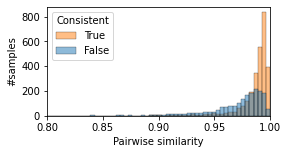

In [27]:
plt.figure(figsize=(4,2))
sns.histplot(data=data[data.pred_type=="any"], x="pairwise_sim", hue="is_consistent", bins=80)
plt.xlim([0.8,1])
plt.xlabel("Pairwise similarity")
plt.ylabel("#samples")
plt.legend(title='Consistent', loc='upper left', labels=['True', 'False'])
plt.savefig("/cephyr/users/lovhag/Alvis/projects/rome/images/llama_sim_cons_any_te.svg")
plt.show()

In [13]:
data[data.pred_type=="any"].pairwise_sim.mean()

0.9862472665675222

In [14]:
data[data.pred_type=="any"].pairwise_sim.min()

0.5438697636127472

In [15]:
data[data.pred_type=="any"].pairwise_sim.std()

0.023037287700912915

## TE and consistency interaction

For sample TE

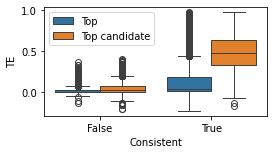

In [28]:
plt.figure(figsize=(4,2))
ax = sns.boxplot(data=data, x="is_consistent", y="sample_te", hue="pred_type")
plt.xlabel("Consistent")
plt.ylabel("TE")
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ["Top", "Top candidate"])
plt.savefig("/cephyr/users/lovhag/Alvis/projects/rome/images/llama_te_cons.svg")
plt.show()

Samples with negative TE remain for LLaMA, what do these look like?

In [29]:
data[data.sample_te<-0.1]

,sample_ix,lama_ix,subject,lama_template,sample_template,lama_answer,sample_answer,correct_answer,lama_correct,sample_correct,lama_te,sample_te,is_consistent,pairwise_sim,subj_len,token_ix,pred_type,relation
13226,208,203,Charles II of Spain,{} is a citizen of,"{}, who holds a citizenship of",Spain,the,Spain,True,False,0.157735,-0.101389,False,0.994974,4,0,any,P27
13227,208,203,Charles II of Spain,{} is a citizen of,"{}, who holds a citizenship of",Spain,Spain,Spain,True,True,0.157735,-0.101389,True,0.994974,4,0,candidate,P27
15828,2318,2317,France Gall,{} is a citizen of,"{}, a citizen of",France,the,France,True,False,0.297876,-0.155906,False,0.993130,2,0,any,P27
15829,2318,2317,France Gall,{} is a citizen of,"{}, a citizen of",France,France,France,True,True,0.297876,-0.155906,True,0.993130,2,0,candidate,P27
15978,2437,2436,Oscar I of Sweden,{} is a citizen of,"{}, a citizen of",Sweden,the,Sweden,True,False,0.075528,-0.155469,False,0.990451,4,0,any,P27
15979,2437,2436,Oscar I of Sweden,{} is a citizen of,"{}, a citizen of",Sweden,Sweden,Sweden,True,True,0.075528,-0.155469,True,0.990451,4,0,candidate,P27
15980,2438,2436,Oscar I of Sweden,{} is a citizen of,"{}, who is a citizen of",Sweden,the,Sweden,True,False,0.075528,-0.158358,False,0.985088,4,0,any,P27
15981,2438,2436,Oscar I of Sweden,{} is a citizen of,"{}, who is a citizen of",Sweden,Sweden,Sweden,True,True,0.075528,-0.158358,True,0.985088,4,0,candidate,P27
17478,3683,3682,Benedict of Poland,{} is a citizen of,"{}, a citizen of",Poland,Poland,Poland,True,True,0.144154,-0.138335,True,0.987067,4,1,candidate,P27
17748,3886,3885,Charles VI of France,{} is a citizen of,"{}, a citizen of",France,the,France,True,False,0.140087,-0.127637,False,0.990558,4,0,any,P27


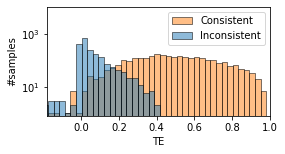

In [30]:
plt.figure(figsize=(4,2))
ax = sns.histplot(data=data[data.pred_type=="any"], x="sample_te", hue="is_consistent", bins=40)
plt.ylabel("#samples")
plt.xlabel("TE")
plt.yscale("log")
plt.xlim([-0.18,1])
plt.ylim([0.8,1e4])
plt.legend(["Consistent", "Inconsistent"])
plt.savefig("/cephyr/users/lovhag/Alvis/projects/rome/images/llama_te_cons_hist.svg", bbox_inches="tight")
plt.show()

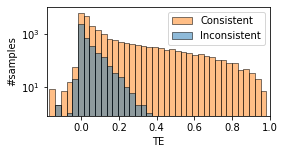

In [31]:
plt.figure(figsize=(4,2))
ax = sns.histplot(data=data[data.pred_type=="candidate"], x="sample_te", hue="is_consistent", bins=40)
plt.ylabel("#samples")
plt.xlabel("TE")
plt.yscale("log")
plt.xlim([-0.18,1])
plt.ylim([0.8,1e4])
plt.legend(["Consistent", "Inconsistent"])
plt.savefig("/cephyr/users/lovhag/Alvis/projects/rome/images/llama_te_cons_candidate_hist.svg", bbox_inches="tight")
plt.show()

For LAMA TE

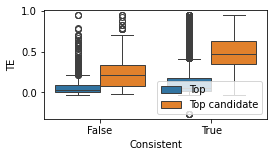

In [32]:
plt.figure(figsize=(4,2))
ax = sns.boxplot(data=data, x="is_consistent", y="lama_te", hue="pred_type")
plt.xlabel("Consistent")
plt.ylabel("TE")
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ["Top", "Top candidate"])
#plt.savefig("/cephyr/users/lovhag/Alvis/projects/rome/images/te_cons.svg")
plt.show()

In [33]:
data.groupby(["pred_type", "is_consistent"]).sample_te.count()

pred_type  is_consistent
any        False             1911
           True              2829
candidate  False             3824
           True             21595
Name: sample_te, dtype: int64

## TE and accuracy interaction

For top

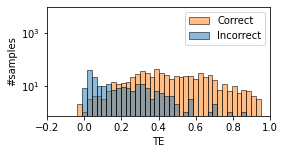

In [34]:
plt.figure(figsize=(4,2))
ax = sns.histplot(data=data[data.pred_type=="any"].groupby(["lama_ix", "relation"]).mean(), x="lama_te", hue="lama_correct", bins=38)
plt.ylabel("#samples")
plt.xlabel("TE")
plt.yscale("log")
plt.xlim([-0.2,1])
plt.ylim([0.7, 10000])
#handles, _ = ax.get_legend_handles_labels()
#ax.legend(handles, ["Incorrect", "Correct"])
plt.legend(["Correct", "Incorrect"])
plt.savefig("/cephyr/users/lovhag/Alvis/projects/rome/images/llama_te_correct.svg", bbox_inches="tight")
plt.show()

In [35]:
len(data[data.pred_type=="any"].groupby(["lama_ix", "relation"]).mean())

795

For top candidate and not being top prediction

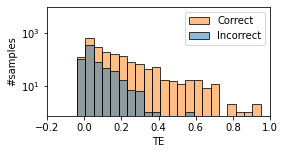

In [36]:
cols_subset = list(data.columns)
cols_subset.remove("pred_type")
cand_dups = data.duplicated(cols_subset)
#need to de-duplicate LAMA template results

plt.figure(figsize=(4,2))
ax = sns.histplot(data=data[~(cand_dups) & (data.pred_type=="candidate")].groupby(["lama_ix", "relation"]).mean(), x="lama_te", hue="lama_correct", bins=27)
plt.ylabel("#samples")
plt.xlabel("TE")
plt.yscale("log")
plt.xlim([-0.2,1])
plt.ylim([0.7, 10000])
#handles, _ = ax.get_legend_handles_labels()
#ax.legend(handles, ["Incorrect", "Correct"])
plt.legend(["Correct", "Incorrect"])
plt.savefig("/cephyr/users/lovhag/Alvis/projects/rome/images/llama_te_correct_candidate.svg", bbox_inches="tight")
plt.show()

In [31]:
len(data[~(cand_dups) & (data.pred_type=="candidate")].groupby(["lama_ix", "relation"]).mean())

2560

## TE threshold

To ensure that we only measure fact associations for a memory recall process, we restrict our analysis to samples for which perturbing the subject yields a lower probability of the traced object compared to the unperturbed case. I.e. the total effect as defined by Meng et al. is positive.

> We need to be able to show that we can perform causal tracing also for incorrect predictions. The ROME CT results by the ROME authors had a mean TE of 0.229, with minimum around -0.2 and maximum around 1. We match this by thresholding the TE of our CT results to be above 0.1.

In [39]:
te_thresh = 0.1
data = data[(data.sample_te>te_thresh) & (data.lama_te>te_thresh)]
print(f"{len(data)} data samples have a TE above 0.1")

8903 data samples have a TE above 0.1


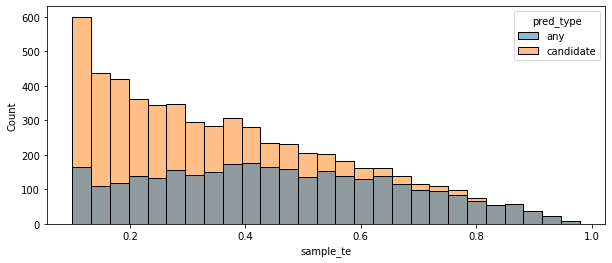

In [40]:
plt.figure(figsize=(10,4))
sns.histplot(data=data, x="sample_te", hue="pred_type")
plt.show()

In [41]:
data.groupby("pred_type")[["sample_te", "lama_te"]].agg(["mean", "count"])

sample_te         lama_te      
               mean count      mean count
pred_type                                
any        0.459764  3130  0.489588  3130
candidate  0.375529  5773  0.354768  5773

In [42]:
data.groupby("pred_type")[["sample_te", "lama_te"]].agg(["mean", "count"])

sample_te         lama_te      
               mean count      mean count
pred_type                                
any        0.459764  3130  0.489588  3130
candidate  0.375529  5773  0.354768  5773

The results for the LAMA template re-occurs for each paraphrase and needs to be de-duplicated.

In [43]:
data[data.pred_type=="any"].groupby(["lama_ix", "relation"]).mean().lama_te.mean()

0.46524459090550235

In [44]:
data[data.pred_type=="candidate"].groupby(["lama_ix", "relation"]).mean().lama_te.mean()

0.3402846123938147

In [45]:
len(data[data.pred_type=="candidate"].groupby(["lama_ix", "relation"]).mean().lama_te)

1095

## The makeup of the data

In [46]:
data[data.pred_type=="any"].relation.value_counts()

P27      2003
P19       594
P1376     260
P101      139
P495       62
P740       52
P20        20
Name: relation, dtype: int64

In [47]:
data[data.pred_type=="candidate"].relation.value_counts()

P27      3028
P740     1118
P19       755
P495      380
P1376     284
P20       155
P101       53
Name: relation, dtype: int64

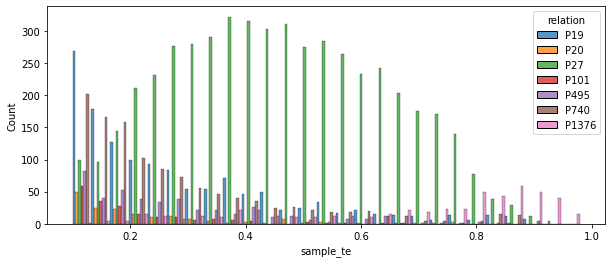

In [48]:
plt.figure(figsize=(10,4))
sns.histplot(data=data, x="sample_te", hue="relation", multiple="dodge")
plt.show()

In [49]:
pd.set_option('display.min_rows', 500)
pd.set_option('display.max_rows', 1000)
data.sort_values(["relation", "subject", "lama_template", "sample_template", "lama_answer"])

,sample_ix,lama_ix,subject,lama_template,sample_template,lama_answer,sample_answer,correct_answer,lama_correct,sample_correct,lama_te,sample_te,is_consistent,pairwise_sim,subj_len,token_ix,pred_type,relation
21022,1077,1071,Adolphe Quetelet,{} works in the field of,{} works in the area of,statistics,statistics,mathematics,False,False,0.225234,0.132421,True,0.996642,6,0,any,P101
21023,1077,1071,Adolphe Quetelet,{} works in the field of,{} works in the area of,statistics,statistics,mathematics,False,False,0.225234,0.132421,True,0.996642,6,0,candidate,P101
20062,433,427,Al-Kindi,{} works in the field of,{} works in the area of,logic,logic,mathematics,False,False,0.126814,0.111404,True,0.989695,4,0,any,P101
20063,433,427,Al-Kindi,{} works in the field of,{} works in the area of,logic,logic,mathematics,False,False,0.126814,0.111404,True,0.989695,4,0,candidate,P101
21137,1161,1155,Alfred Tarski,{} works in the field of,{} works in the area of,logic,logic,logic,True,True,0.181767,0.134881,True,0.984549,3,1,candidate,P101
21136,1161,1155,Alfred Tarski,{} works in the field of,{} works in the area of,mathematical,mathematical,logic,False,False,0.404471,0.295859,True,0.988134,3,0,any,P101
21129,1157,1155,Alfred Tarski,{} works in the field of,{}'s area of work is,logic,logic,logic,True,True,0.181767,0.137328,True,0.986184,3,1,candidate,P101
20051,426,420,Anita Borg,{} works in the field of,{} works in the area of,computer,computer,mathematics,False,False,0.288489,0.131374,True,0.993498,3,0,any,P101
21096,1128,1127,Anton Zeilinger,{} works in the field of,{} specializes in,quantum,quantum,physics,False,False,0.676763,0.350581,True,0.970893,4,0,any,P101
21106,1133,1127,Anton Zeilinger,{} works in the field of,{} works in the area of,quantum,quantum,physics,False,False,0.676763,0.556062,True,0.994000,4,0,any,P101


## Consistency results
We are also interested in model consistency. We can here observe how the model is generally more consistent when we filter the output for candidates, but that it does not achieve perfect consistency. 

> Note that these consistency values only are measured for pairwise comparisons between the LAMA template and other paraphrases.

In [50]:
data.groupby("pred_type").is_consistent.agg(["mean", "count"])

,mean,count
pred_type,,
any,0.880511,3130
candidate,0.959640,5773


## Accuracy results
We show that a high TE value can be measured even when the model is not correct. For all results below the TE is higher than 0.1.

In [51]:
data.groupby("pred_type")[["lama_correct", "sample_correct"]].agg(["mean", "count"])

lama_correct       sample_correct      
                  mean count           mean count
pred_type                                        
any           0.902875  3130       0.812460  3130
candidate     0.934869  5773       0.909233  5773

Measure TE and correctness across LAMA templates. Since these are repeated pairwise we need to make sure that we do not double report them.

In [52]:
# number of LAMA queries across all included relations
data[data.pred_type=="any"].groupby(["lama_ix", "relation"]).mean().lama_correct.count()

631

In [53]:
# number of LAMA queries across all included relations
data[data.pred_type=="candidate"].groupby(["lama_ix", "relation"]).mean().lama_correct.sum()

1006.0

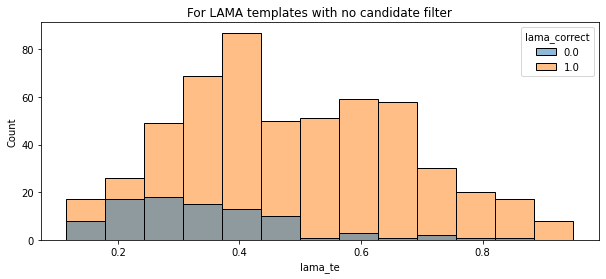

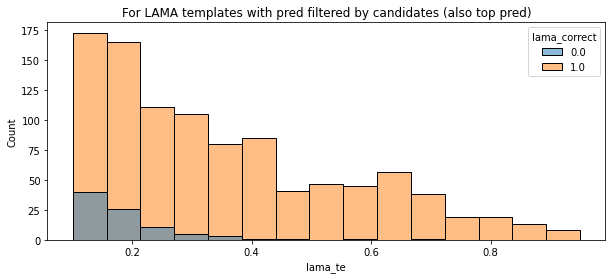

In [54]:
plt.figure(figsize=(10,4))
sns.histplot(data=data[data.pred_type=="any"].groupby(["lama_ix", "relation"]).mean(), x="lama_te", hue="lama_correct")
plt.title("For LAMA templates with no candidate filter")
plt.show()

plt.figure(figsize=(10,4))
sns.histplot(data=data[data.pred_type=="candidate"].groupby(["lama_ix", "relation"]).mean(), x="lama_te", hue="lama_correct")
plt.title("For LAMA templates with pred filtered by candidates (also top pred)")
plt.show()

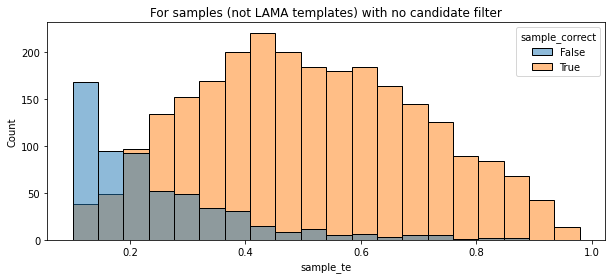

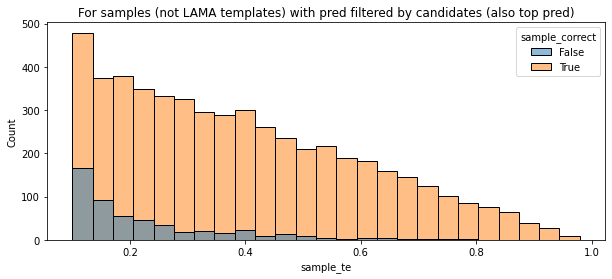

In [55]:
plt.figure(figsize=(10,4))
sns.histplot(data=data[data.pred_type=="any"], x="sample_te", hue="sample_correct")
plt.title("For samples (not LAMA templates) with no candidate filter")
plt.show()

plt.figure(figsize=(10,4))
sns.histplot(data=data[data.pred_type=="candidate"], x="sample_te", hue="sample_correct")
plt.title("For samples (not LAMA templates) with pred filtered by candidates (also top pred)")
plt.show()

In [56]:
cols_subset = list(data.columns)
cols_subset.remove("pred_type")
cand_dups = data.duplicated(cols_subset)
#need to de-duplicate LAMA template results
data[~(cand_dups) & (data.pred_type=="candidate")].groupby(["lama_ix", "relation"]).mean().lama_te.mean()

0.25020374065646117

## Evaluate RQ1

We should be able to observe a correlation between consistent predictions and consistent fact recall, measured as similarity between extracted factual subject associations. 

We report the Spearman correlation between model consistency and extraction pattern similarity.

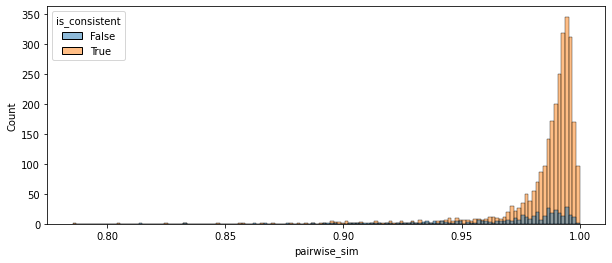

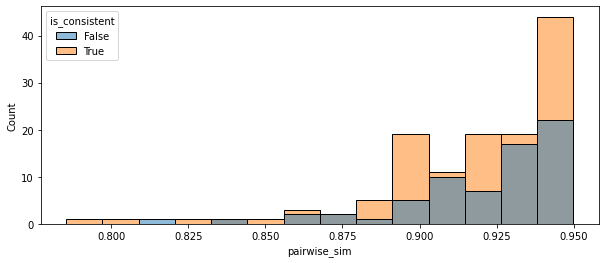

In [57]:
plt.figure(figsize=(10,4))
sns.histplot(data=data[data.pred_type=="any"], x="pairwise_sim", hue="is_consistent")
plt.show()

plt.figure(figsize=(10,4))
sns.histplot(data=data[(data.pred_type=="any") & (data.pairwise_sim<0.95)], x="pairwise_sim", hue="is_consistent")
plt.show()

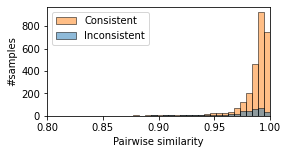

In [58]:
plt.figure(figsize=(4,2))
sns.histplot(data=data[data.pred_type=="any"], x="pairwise_sim", hue="is_consistent", bins=40)
plt.xlim([0.8,1])
plt.xlabel("Pairwise similarity")
plt.ylabel("#samples")
plt.legend(loc='upper left', labels=['Consistent', 'Inconsistent'])
plt.savefig("/cephyr/users/lovhag/Alvis/projects/rome/images/llama_sim_cons.svg", bbox_inches="tight")
plt.show()

In [59]:
data[data.pred_type=="any"].pairwise_sim.mean()

0.9842303419404986

In [60]:
data[data.pred_type=="any"].pairwise_sim.min()

0.7854689717292785

In [61]:
data[data.pred_type=="any"].pairwise_sim.std()

0.020184585326275116

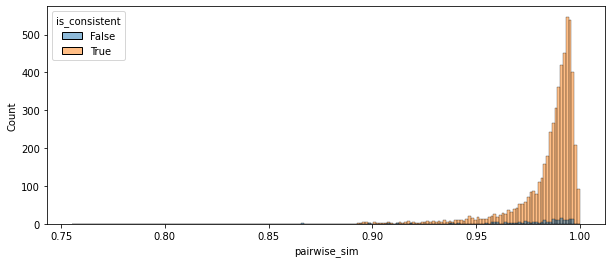

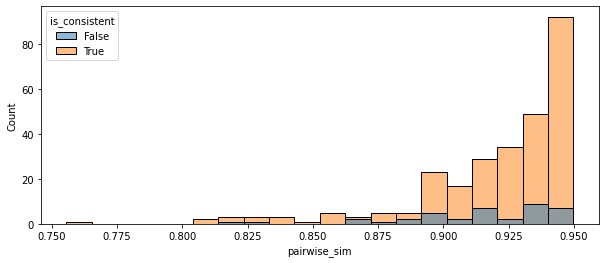

In [62]:
plt.figure(figsize=(10,4))
sns.histplot(data=data[data.pred_type=="candidate"], x="pairwise_sim", hue="is_consistent")
plt.show()

plt.figure(figsize=(10,4))
sns.histplot(data=data[(data.pred_type=="candidate") & (data.pairwise_sim<0.95)], x="pairwise_sim", hue="is_consistent")
plt.show()

In [63]:
test_data = data[data.pred_type=="any"].copy()

print(scipy.stats.spearmanr(test_data.is_consistent, 
                      test_data.pairwise_sim))
print(f"Number of samples: {len(test_data)}, of which {(len(test_data[test_data.is_consistent]))} are consistent.")

SpearmanrResult(correlation=0.23640592879817393, pvalue=5.191018095556504e-41)
Number of samples: 3130, of which 2756 are consistent.


In [64]:
test_data = data[data.pred_type=="candidate"].copy()

print(scipy.stats.spearmanr(test_data.is_consistent, 
                      test_data.pairwise_sim))
print(f"Number of samples: {len(test_data)}, of which {(len(test_data[test_data.is_consistent]))} are consistent.")

SpearmanrResult(correlation=0.11465422054916662, pvalue=2.3643446959639913e-18)
Number of samples: 5773, of which 5540 are consistent.


## Error analysis

In [58]:
data[data.is_consistent==False].groupby(["lama_answer","sample_answer"]).agg({"lama_te": "mean", "sample_te": "mean", "pairwise_sim": ["mean","count"]})


lama_te sample_te pairwise_sim      
                                mean      mean         mean count
lama_answer  sample_answer                                       
Afghan       Iran           0.324454  0.161064     0.990941     3
Argentina    Brazil         0.153773  0.132403     0.988706     4
             Italy          0.213848  0.161959     0.994358     9
             both           0.293680  0.200761     0.991353     2
Atlanta      the            0.238463  0.185519     0.959947     3
Australia    England        0.117411  0.130474     0.991102     3
             Italy          0.109874  0.127304     0.986217     1
             the            0.198851  0.122079     0.985322     2
Austria      Germany        0.209997  0.183683     0.987095    13
             Switzerland    0.191804  0.221848     0.988254     1
B            Der            0.180711  0.116019     0.995407     1
Baltimore    the            0.212416  0.132783     0.955022     3
Barcelona    Spain          0.199415  0.123255     0.983873     8
             a              0.443708  0.128540     0.982953     3
             the            0.224476  0.123103     0.982241     1
Berlin       Germany        0.227093  0.146119     0.945838    16
             Pr             0.424839  0.122283     0.976522     1
Bil          the            0.200595  0.107035     0.969968     2
Boston       Brook          0.366297  0.175357     0.874219     2
Brazil       both           0.595958  0.278016     0.995054     1
             the            0.376159  0.203584     0.986615     3
Budapest     Hung           0.320151  0.124324     0.960598     3
Canada       China          0.337909  0.188711     0.989929     1
             France         0.141234  0.147743     0.984401     4
             India          0.129215  0.106165     0.991562     1
             New            0.198179  0.145592     0.993650     1
             Nova           0.405140  0.117793     0.990732     1
             Toronto        0.326393  0.283253     0.959186     8
             Ukraine        0.282858  0.204284     0.985506     7
             both           0.381514  0.225483     0.987889     7
             the            0.388732  0.346210     0.985662     2
Chicago      the            0.552734  0.190575     0.968043     1
China        both           0.475029  0.203608     0.988205     3
Dallas       a              0.497780  0.126848     0.983239     2
Den          both           0.283758  0.210011     0.978028     1
Detroit      a              0.432371  0.164255     0.913783     1
             the            0.402606  0.199657     0.911046     1
Dublin       County         0.140334  0.110028     0.964010     1
             Ireland        0.431199  0.191243     0.912626    10
             the            0.399921  0.112850     0.978346     4
Edinburgh    Scotland       0.240914  0.169274     0.963487    13
             the            0.332864  0.112498     0.974174     1
Egypt        both           0.428069  0.171556     0.988817     5
England      Australia      0.207136  0.209443     0.996319     1
             London         0.351005  0.123749     0.996619     1
             the            0.374267  0.228460     0.994780     6
Florida      a              0.665974  0.104949     0.952658     1
Germany      Austria        0.127310  0.138428     0.986531     1
             the            0.256366  0.138146     0.989951     1
Glasgow      a              0.334984  0.104491     0.962515     1
             the            0.130985  0.117245     0.988219     2
Greece       both           0.481705  0.219476     0.997030     1
             the            0.394303  0.168625     0.991961     3
Hamburg      Germany        0.220336  0.132071     0.964319     1
Hong         the            0.309432  0.107884     0.927977     1
Hope         Ark            0.618291  0.320395     0.906803     2
Houston      the            0.486430  0.134049     0.947722     4
India        And            0.566081  0.240379     0.983444     1
   

Is it the case that the model for "the" or "a" sample predictions also ranks the LAMA predicted token highly?

In [59]:
the_ixs = data[(data.is_consistent==False) & (data.sample_answer.isin(forbidden_predictions))][["relation","sample_ix"]]
data_mask = data.apply(lambda row: row.sample_ix in list(the_ixs[the_ixs.relation==row.relation].sample_ix), axis=1)
data[data_mask]

,sample_ix,lama_ix,subject,lama_template,sample_template,lama_answer,sample_answer,correct_answer,lama_correct,sample_correct,lama_te,sample_te,is_consistent,pairwise_sim,subj_len,token_ix,pred_type,relation
20,12,7,Moe Koffman,{} was born in,{} originated from,Toronto,a,Toronto,True,False,0.261585,0.116383,False,0.986505,5,0,any,P19
21,12,7,Moe Koffman,{} was born in,{} originated from,Toronto,Toronto,Toronto,True,True,0.261585,0.116383,True,0.986505,5,0,candidate,P19
32,19,14,Kurt Schwertsik,{} was born in,{} originated from,Vienna,a,Vienna,True,False,0.348210,0.160698,False,0.984588,5,0,any,P19
33,19,14,Kurt Schwertsik,{} was born in,{} originated from,Vienna,Vienna,Vienna,True,True,0.348210,0.160698,True,0.984588,5,0,candidate,P19
368,215,210,Killer Mike,{} was born in,{} originated from,Atlanta,the,Atlanta,True,False,0.308259,0.252702,False,0.975089,3,0,any,P19
369,215,210,Killer Mike,{} was born in,{} originated from,Atlanta,Atlanta,Atlanta,True,True,0.308259,0.252702,True,0.975089,3,0,candidate,P19
564,333,329,India Hicks,{} was born in,{} was native to,London,the,London,True,False,0.598102,0.146103,False,0.970086,3,0,any,P19
565,333,329,India Hicks,{} was born in,{} was native to,London,London,London,True,True,0.598102,0.146103,True,0.970086,3,0,candidate,P19
572,338,336,Big Gipp,{} was born in,{} was originally from,Atlanta,the,Atlanta,True,False,0.203565,0.104960,False,0.976922,3,0,any,P19
573,338,336,Big Gipp,{} was born in,{} was originally from,Atlanta,Atlanta,Atlanta,True,True,0.203565,0.104960,True,0.976922,3,0,candidate,P19


In [60]:
data[(data.is_consistent==True) & (data.pairwise_sim<0.95)].groupby(["lama_answer","sample_answer"]).agg({"lama_te": "mean", "sample_te": "mean", "pairwise_sim": ["mean","count"]})


lama_te sample_te pairwise_sim      
                                mean      mean         mean count
lama_answer  sample_answer                                       
Atlanta      Atlanta        0.242695  0.445774     0.927232    12
Australia    Australia      0.109874  0.155835     0.949245     1
Baltimore    Baltimore      0.206971  0.258723     0.925025     8
Barcelona    Barcelona      0.662031  0.460855     0.936813     4
Berlin       Berlin         0.259704  0.142266     0.926753     1
Bog          Bog            0.162012  0.128759     0.890613     1
Boston       Boston         0.226425  0.278275     0.888606    11
Brazil       Brazil         0.167610  0.471569     0.932447     1
Budapest     Budapest       0.238527  0.152732     0.915414     4
Chicago      Chicago        0.562522  0.612675     0.922429    25
Dallas       Dallas         0.140989  0.139717     0.938508     2
Detroit      Detroit        0.586919  0.517400     0.905018    18
Dresden      Dresden        0.129113  0.327108     0.926988     1
Dublin       Dublin         0.658822  0.428436     0.929147    18
Egypt        Egypt          0.123902  0.251417     0.942377     4
England      England        0.211875  0.342362     0.937425     2
Florence     Florence       0.199158  0.110610     0.806627     1
France       France         0.137885  0.539324     0.947062     1
Gary         Gary           0.866951  0.860572     0.945893     4
Germany      Germany        0.266523  0.455007     0.933643     7
Glasgow      Glasgow        0.200303  0.357889     0.928368     6
Goth         Goth           0.402998  0.505934     0.920778     5
Hamburg      Hamburg        0.185182  0.319595     0.938551     2
Hamilton     Hamilton       0.135662  0.324074     0.911357     3
Hope         Hope           0.618291  0.413099     0.923558    10
Houston      Houston        0.231595  0.239942     0.903878     3
India        India          0.323008  0.402049     0.937179     5
Iran         Iran           0.600033  0.615207     0.949628     4
Ireland      Ireland        0.251321  0.176685     0.945304     2
Italy        Italy          0.219814  0.284419     0.937692     6
Japan        Japan          0.267255  0.248607     0.923899    19
Jerusalem    Jerusalem      0.707931  0.182877     0.894101     1
Liverpool    Liverpool      0.618708  0.849568     0.944788     2
London       London         0.381533  0.257730     0.923491    22
Madrid       Madrid         0.213616  0.205687     0.846955     2
Manchester   Manchester     0.282213  0.283263     0.929944     4
Melbourne    Melbourne      0.169904  0.156190     0.929361     8
Mexico       Mexico         0.333877  0.284662     0.935702     7
Milan        Milan          0.420440  0.217897     0.912650     4
Montreal     Montreal       0.355694  0.333331     0.910188    39
Moscow       Moscow         0.253283  0.168599     0.923511     3
New          New            0.571238  0.211703     0.945043     1
Norway       Norway         0.174189  0.109699     0.938265     1
Paris        Paris          0.335174  0.259435     0.922171    11
Pe           Pe             0.423866  0.471413     0.949997     1
Peru         Peru           0.257029  0.103113     0.926485     1
Philadelphia Philadelphia   0.455185  0.408706     0.919467    24
Portugal     Portugal       0.157473  0.196530     0.933931     3
Rome         Rome           0.305626  0.386220     0.906403    20
Scotland     Scotland       0.123449  0.245886     0.935961     2
Seattle      Seattle        0.324698  0.487454     0.916965    12
Stockholm    Stockholm      0.248417  0.149660     0.922132     4
Sydney       Sydney         0.223711  0.156682     0.939004     2
Toronto      Toronto        0.192248  0.195336     0.935183     5
Ukraine      Ukraine        0.649370  0.579989     0.926109     8
Vienna       Vienna         0.335813  0.232081     0.917984    11
algebraic    algebraic      0.277413  0.183563     0.853906     4
evolution    evolution      0.597099  0.263977     0.948226     2
phi

In [61]:
data[data.subject=="Bertil Lindblad"]

,sample_ix,lama_ix,subject,lama_template,sample_template,lama_answer,sample_answer,correct_answer,lama_correct,sample_correct,lama_te,sample_te,is_consistent,pairwise_sim,subj_len,token_ix,pred_type,relation
12978,15,14,Bertil Lindblad,{} is a citizen of,"{}, a citizen of",Sweden,Sweden,Sweden,True,True,0.436806,0.548095,True,0.989362,5,0,any,P27
12979,15,14,Bertil Lindblad,{} is a citizen of,"{}, a citizen of",Sweden,Sweden,Sweden,True,True,0.436806,0.548095,True,0.989362,5,0,candidate,P27
12980,16,14,Bertil Lindblad,{} is a citizen of,"{}, who is a citizen of",Sweden,Sweden,Sweden,True,True,0.436806,0.537020,True,0.993324,5,0,any,P27
12981,16,14,Bertil Lindblad,{} is a citizen of,"{}, who is a citizen of",Sweden,Sweden,Sweden,True,True,0.436806,0.537020,True,0.993324,5,0,candidate,P27
12982,17,14,Bertil Lindblad,{} is a citizen of,{} holds a citizenship of,Sweden,Sweden,Sweden,True,True,0.436806,0.629547,True,0.994939,5,0,any,P27
12983,17,14,Bertil Lindblad,{} is a citizen of,{} holds a citizenship of,Sweden,Sweden,Sweden,True,True,0.436806,0.629547,True,0.994939,5,0,candidate,P27
12984,18,14,Bertil Lindblad,{} is a citizen of,{} has a citizenship of,Sweden,Sweden,Sweden,True,True,0.436806,0.723722,True,0.987852,5,0,any,P27
12985,18,14,Bertil Lindblad,{} is a citizen of,{} has a citizenship of,Sweden,Sweden,Sweden,True,True,0.436806,0.723722,True,0.987852,5,0,candidate,P27
12986,19,14,Bertil Lindblad,{} is a citizen of,"{}, who holds a citizenship of",Sweden,Sweden,Sweden,True,True,0.436806,0.576425,True,0.989849,5,0,any,P27
12987,19,14,Bertil Lindblad,{} is a citizen of,"{}, who holds a citizenship of",Sweden,Sweden,Sweden,True,True,0.436806,0.576425,True,0.989849,5,0,candidate,P27
